<a href="https://colab.research.google.com/github/DaeSeokSong/ANPR-NPDP/blob/main/NPDP_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

*   [Github 1](https://github.com/kairess/ANPR-with-Yolov4)
*   [Github 2](https://github.com/kairess/license_plate_recognition)



# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/DeepLearning/Project/NPDP_Beta
!ls -al

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning/Project/NPDP_Beta
total 1263
drwx------ 2 root root    4096 Oct  6 05:25 darknet
drwx------ 2 root root    4096 Oct  6 05:07 Dataset
drwx------ 2 root root    4096 Oct  6 13:14 npdp
-rw------- 1 root root 1280003 Oct  7 18:50 NPDP_Beta.ipynb


# Git
***Do it only once for the first time***

In [ ]:
"""
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!ls -al

!git clone https://github.com/kairess/super_resolution
"""

Cloning into 'super_resolution'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


# Install Package
***Activating the virtual environment***

In [ ]:
!sudo pip install virtualenv
!virtualenv npdp
!source npdp/bin/activate

!apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python==4.5.3.56
!cp ./Dataset/kor.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

     |████████████████████████████████| 5.3 MB 5.2 MB/s 
     |████████████████████████████████| 496 kB 51.6 MB/s 
created virtual environment CPython3.7.12.final.0-64 in 17072ms
  creator CPython3Posix(dest=/content/gdrive/MyDrive/DeepLearning/Project/NPDP_Beta/npdp, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==21.2.4, setuptools==58.1.0, wheel==0.37.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,79

# Import

In [ ]:
%cd /content/gdrive/MyDrive/DeepLearning/Project/NPDP_Beta

# ANPR
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

# Upscailing
import os, glob
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

!tesseract --list-langs
cv2.__version__

/content/gdrive/MyDrive/DeepLearning/Project/NPDP_Beta


ModuleNotFoundError: ignored

# Function

In [ ]:
def find_chars(contour_list) :
        matched_result_idx = []
        
        for d1 in contour_list :
            matched_contours_idx = []
            for d2 in contour_list :
                if d1['idx'] == d2['idx'] : continue

                dx = abs(d1['cx'] - d2['cx'])
                dy = abs(d1['cy'] - d2['cy'])

                diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

                distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) # 두 벡터간 거리
                if dx == 0:
                    angle_diff = 90
                else:
                    angle_diff = np.degrees(np.arctan(dy / dx)) # 세타(각도) 구하기
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                width_diff = abs(d1['w'] - d2['w']) / d1['w']
                height_diff = abs(d1['h'] - d2['h']) / d1['h']

                if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF :
                    matched_contours_idx.append(d2['idx'])

            # append this contour
            matched_contours_idx.append(d1['idx'])

            if len(matched_contours_idx) < MIN_N_MATCHED: continue # 조건 수 충족했는지 체크

            matched_result_idx.append(matched_contours_idx)

            unmatched_contour_idx = []
            for d4 in contour_list :
                if d4['idx'] not in matched_contours_idx : unmatched_contour_idx.append(d4['idx']) 

            unmatched_contour = np.take(possible_contours, unmatched_contour_idx) # a에서 인덱스 추출
            
            # recursive
            recursive_contour_list = find_chars(unmatched_contour)
            for idx in recursive_contour_list: matched_result_idx.append(idx)

            break

        return matched_result_idx

# Main

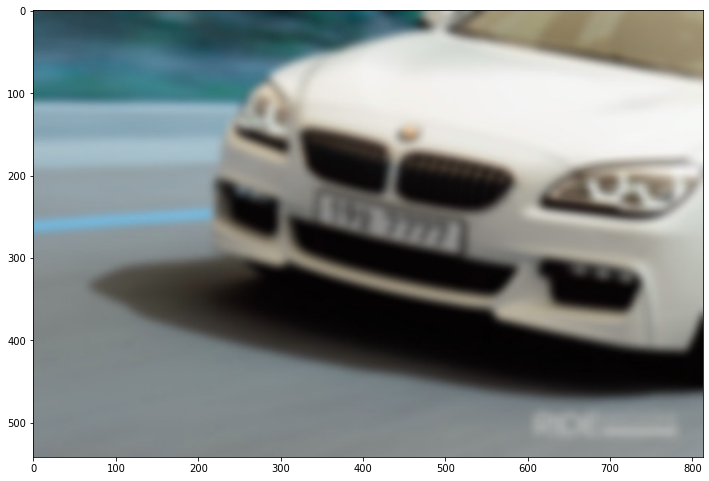

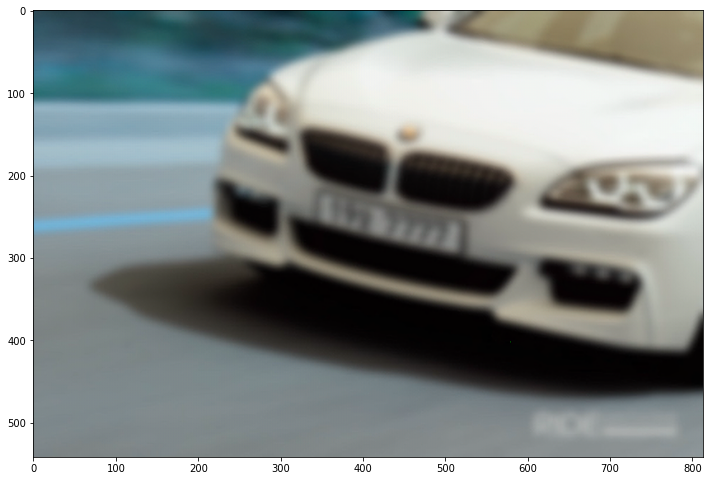

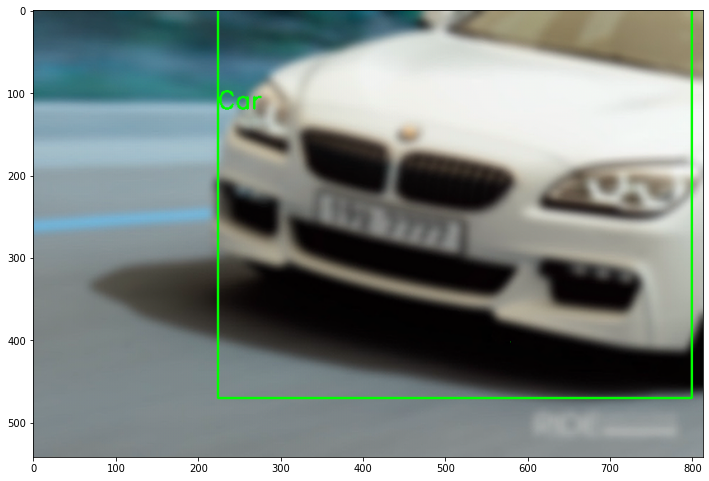

In [ ]:
CONFIDENCE = 0.9
THRESHOLD = 0.3
LABELS = ['Car', 'Number Plate']
CAR_WIDTH_TRESHOLD = 500

if __name__ == '__main__' :
    img = cv2.imread('./Dataset/TestImages/blurred_NumberPlate01.jpg')
    H, W, channel = img.shape

    # ▼▼▼▼▼ Detect Car and Number plate in image ▼▼▼▼▼
    net = cv2.dnn.readNetFromDarknet('./Dataset/cfg/yolov4-ANPR.cfg', './Dataset/yolov4-ANPR.weights')

    blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(416, 416), swapRB=True)
    net.setInput(blob)
    output = net.forward()

    # NMS
    bboxes, confidences, class_ids = [], [], []
    for det in output :
        box = det[:4]
        scores = det[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > CONFIDENCE :
            cx, cy, w, h = box * np.array([W, H, W, H])
            x = cx - (w/2)
            y = cy - (h/2)

            bboxes.append([int(x), int(y), int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

    idxs = cv2.dnn.NMSBoxes(bboxes, confidences, CONFIDENCE, THRESHOLD)
    
    # ▼▼▼▼▼ Image Super Resolution ▼▼▼▼▼
    if len(idxs) % 2 != 0 :
        # print original image
        plt.title("Image before super_resolution")
        plt.figure(figsize=(12,10))
        plt.imshow(img);
        plt.show();
        
        # redetect License Number Plate
        blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(416, 416), swapRB=True)
        net.setInput(blob)
        output = net.forward()

        # NMS
        bboxes, confidences, class_ids = [], [], []
        for det in output :
            box = det[:4]
            scores = det[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > CONFIDENCE :
                cx, cy, w, h = box * np.array([W, H, W, H])
                x = cx - (w/2)
                y = cy - (h/2)

                bboxes.append([int(x), int(y), int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

        idxs = cv2.dnn.NMSBoxes(bboxes, confidences, CONFIDENCE, THRESHOLD)

    # ▼▼▼▼▼ ONLY Detect License number plate and Print ▼▼▼▼▼
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # maximize contrast
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    # blur and threshold
    img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0) # delete noise on image

    img_blurred_thresh = cv2.adaptiveThreshold( # image convert to black or white
        img_blurred,
        maxValue=255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=19,
        C=9
    )

    # find contours
    contours, _ = cv2.findContours( # find outline on image
        img_blurred_thresh,
        mode=cv2.RETR_LIST,
        method=cv2.CHAIN_APPROX_SIMPLE
    )

    # prepare data
    contours_dict = []
    for contour in contours :
        x, y, w, h = cv2.boundingRect(contour)

        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w/2), # center x
            'cy': y + (h/2) # center y
        })
    
    # select candidates by char size
    MIN_AREA = 80
    MIN_WIDTH, MIN_HEIGHT = 2, 8
    MIN_RATIO, MAX_RATIO = 0.25, 1.0

    possible_contours = []
    cnt = 0
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO :
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    # select candidates by arrangement of contours
    MAX_DIAG_MULTIPLYER = 5 # 컨투어끼리의 중간 좌표 차이가 5배 이내에 있어야 한다.
    MAX_ANGLE_DIFF = 12.0 # 세타의 최대값
    MAX_AREA_DIFF = 0.5 # 두 컨투어간의 면적차이
    MAX_WIDTH_DIFF = 0.8
    MAX_HEIGHT_DIFF = 0.2
    MIN_N_MATCHED = 3 # 위 조건을 만족해야 하는 최소 개수
    
    result_idx = find_chars(possible_contours)

    matched_result = []
    for idx_list in result_idx:
        matched_result.append(np.take(possible_contours, idx_list))

    # rotate number plate image
    PLATE_WIDTH_PADDING = 1.3 # 1.3
    PLATE_HEIGHT_PADDING = 1.5 # 1.5
    MIN_PLATE_RATIO = 3
    MAX_PLATE_RATIO = 10

    plate_imgs = []
    plate_infos = []
    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx']) # x 방향에 순차적으로 정렬
        
        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
        
        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
        
        sum_height = 0
        for d in sorted_chars: sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
        
        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy'] # 직각삼각형의 높이
        triangle_hypotenus = np.linalg.norm( # 직각삼각형의 빗변 길이
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )
        
        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) # 두 지점간 직선 거리를 빗변으로 한 직각삼각형의 세타(각도)
        
        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0) # 로태이션 매트릭스를 구한다.

        img_rotated = cv2.warpAffine(img_blurred_thresh, M=rotation_matrix, dsize=(W, H)) # 이미지 변형

        img_cropped = cv2.getRectSubPix( # 회전된 이미지에서 원하는 부분만 자른다.
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )
        
        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] > MAX_PLATE_RATIO :
            continue

        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })

        plt.subplot(len(matched_result), 1, i+1)
        plt.imshow(img_cropped, cmap='gray')
        plt.show()

    # another thresholding to find chars
    longest_idx, longest_text = -1, 0
    plate_chars = []

    for i, plate_img in enumerate(plate_imgs):
        plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
        _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        # find contours again (same as above)
        contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
        
        plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
        plate_max_x, plate_max_y = 0, 0

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            area = w * h
            ratio = w / h

            if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h
                    
        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
        
        img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0) # 노이즈 제거, 조금 흐릿해짐
        _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU) # 임계처리
        img_result = cv2.copyMakeBorder(img_result,
                                        top=10, bottom=10, left=10, right=10,
                                        borderType=cv2.BORDER_CONSTANT,
                                        value=(0,0,0)) # 이미지에 패딩을 준다. value 색으로

        # psm 7 = 이미지에 글자가 한 줄로 정렬되어 있다. oem 0 = pytesseract 중에 0번 모델을 쓰겠다
        chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
        
        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('가') <= ord(c) <= ord('힣') or c.isdigit(): # 숫자나 한글이 포함되어 있는가?
                if c.isdigit(): # 숫자가 하나라도 있는가?
                    has_digit = True
                result_chars += c
        
        print(result_chars)
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text : longest_idx = i

        plt.subplot(len(plate_imgs), 1, i+1)
        plt.imshow(img_result, cmap='gray')
        plt.show()

    # ▼▼▼▼▼ Print Result ▼▼▼▼▼
    if len(idxs) > 0 :
        for i in idxs.flatten() :
            x, y, w, h = bboxes[i]

            cv2.rectangle(img, pt1=[x, y], pt2=(x+w, y+h), color=(0, 255, 0), thickness=2)
            cv2.putText(img, 
                        text='%s' % (LABELS[class_ids[i]]),
                        org=(x, y + 125),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=1,
                        color=(0, 255, 0),
                        thickness=2
            )

    plt.figure(figsize=(12,10))
    plt.imshow(img, cmap='gray')
    plt.show()

# Disable the virtual environment

In [ ]:
!deactivate